In [51]:
import time
import numpy as np
import scanpy as sc
import squidpy as sq
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score
from torch.utils.data import Dataset, random_split, DataLoader
from tqdm.auto import tqdm

In [52]:
# function to get k lowest values from each row of a sparse matrix
def get_k_lowest_values(matrix, k):
    n_rows = matrix.shape[0]
    k_lowest_indices = np.empty((n_rows, k), dtype=int)
    for i in range(n_rows):
        start = matrix.indptr[i]
        end = matrix.indptr[i + 1]
        row_data = matrix.data[start:end]
        row_indices = matrix.indices[start:end]
        k_smallest_indices = np.argpartition(row_data, k)[:k]
        k_lowest_indices[i] = row_indices[k_smallest_indices]
    return k_lowest_indices

In [53]:
adata = sc.read("../example_files/img_1199670929.h5ad")

In [54]:
# now we have the adata object of just a single image
sq.gr.spatial_neighbors(adata=adata, radius=1000, key_added="adjacency_matrix", coord_type="generic")

In [78]:
# we get the 5 closest cells to each cell
number_of_cells_used = 10#
closest_matrix = get_k_lowest_values(adata.obsp['adjacency_matrix_distances'], number_of_cells_used)

In [79]:
# we construct dataset using closest 5 cells

X = []
y = []

for i, cell in tqdm(enumerate(adata.X), total=len(adata)):
    y.append(cell.toarray())
    five_closest_cells = np.array([adata.X[index].toarray() for index in closest_matrix[i]])
    X.append(five_closest_cells.flatten())

X = np.array(X)
y = np.concatenate(y)

  0%|          | 0/26230 [00:00<?, ?it/s]

In [80]:
#X = np.concatenate(X)
print(X.shape, y.shape)

#display(X[0])
#display(y[0])

(26230, 5500) (26230, 550)


array([0.        , 0.        , 0.        , ..., 0.        , 0.77972685,
       0.        ])

array([0.        , 0.        , 0.        , 2.27356674, 0.        ,
       0.        , 0.        , 0.        , 1.54477479, 0.        ,
       0.        , 0.        , 1.54477479, 0.        , 1.54477479,
       0.        , 1.54477479, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 5.36699669,
       1.54477479, 1.54477479, 2.27356674, 4.03039626, 1.54477479,
       0.        , 1.54477479, 2.75547635, 0.        , 0.        ,
       0.        , 1.54477479, 0.        , 1.54477479, 0.        ,
       0.        , 0.        , 0.        , 0.        , 3.85030902,
       1.54477479, 0.        , 1.54477479, 1.54477479, 0.        ,
       1.54477479, 2.27356674, 0.        , 4.03039626, 0.        ,
       3.11608871, 0.        , 1.54477479, 0.        , 2.27356674,
       0.        , 0.        , 0.        , 0.        , 1.54477479,
       2.27356674, 0.        , 0.        , 1.54477479, 0.        ,
       2.27356674, 2.27356674, 0.        , 0.        , 1.54477

In [88]:
# we use 80% of the data for training and 10% for validation and 10% for testing
# Create a custom dataset
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create the dataset and split it into training, validation, and testing sets
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()
dataset = MyDataset(X, y)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

In [89]:
# Create data loaders
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

In [91]:
input_dim = number_of_cells_used * 550

class LinearModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 5*550),
            nn.ReLU(),
            nn.Linear(5*550, 3*550),
            nn.ReLU(),
            nn.Linear(3*550, output_dim)
        )


    def forward(self, x):
        return self.model(x)

In [92]:
# Set device for training, macbook
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create an instance of the model and move it to the device

output_dim = 550

# Create the model
model = LinearModel(input_dim, output_dim).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

# Training loop
num_epochs = 100

# store losses
train_losses = []
val_losses = []

# store r2 scores
train_r2_scores = []
val_r2_scores = []

best_val_loss = float('inf') # Set initial best validation loss to infinity
patience = 5                # Number of epochs to wait for improvement in validation loss
epochs_no_improve = 0        # Number of epochs with no improvement in validation loss
best_epoch = 0               # Epoch at which we get the best validation loss

# epoch training times
epoch_times = []
start_time = time.time()

for epoch in range(num_epochs):

    # store epoch start time
    epoch_start_time = time.time()

    model.train()  # Set the model to training mode
    total_loss = 0
    targets_list = []
    outputs_list = []

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        targets_list.append(targets.cpu().numpy())
        outputs_list.append(outputs.cpu().detach().numpy())

    # Compute and store the average training loss for this epoch
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Calculate R2 score for the training set
    train_targets_all = np.concatenate(targets_list)
    train_outputs_all = np.concatenate(outputs_list)
    train_r2 = r2_score(train_targets_all, train_outputs_all)
    train_r2_scores.append(train_r2)

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0
    val_targets_list = []
    val_outputs_list = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Compute the validation loss
            val_loss = criterion(outputs, targets)
            total_val_loss += val_loss.item()

            val_targets_list.append(targets.cpu().numpy())
            val_outputs_list.append(outputs.cpu().detach().numpy())

        # Compute and store the average validation loss for this epoch
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Calculate R2 score for the validation set
        val_targets_all = np.concatenate(val_targets_list)
        val_outputs_all = np.concatenate(val_outputs_list)
        val_r2 = r2_score(val_targets_all, val_outputs_all)
        val_r2_scores.append(val_r2)

        # record
        epoch_times.append(time.time() - epoch_start_time)

        # predict when training will be finished when early stopping is not triggered based on epoch times and remaining epochs
        remaining_epoch = num_epochs - epoch
        remaining_time = (np.mean(epoch_times) * remaining_epoch)/60

        # Print training and validation results for this epoch
        print(f"Epoch {epoch + 1}/{num_epochs}, Time: {(time.time() - start_time)/60:.2f}/{remaining_time:.2f}m Train Loss: {avg_train_loss:.4f}, Train R2: {train_r2:.4f}, Val Loss: {avg_val_loss:.4f}, Val R2: {val_r2:.4f}, {'↓' if avg_val_loss < best_val_loss else '↑'}")




    # early stopping with patience
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "../models/best_model.pt")
        best_epoch = epoch + 1
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print(f"Early stopping after epoch {epoch + 1}")
            break

print(f"Training finished! Best validation loss: {best_val_loss:.4f} at epoch: {best_epoch}")

Epoch 1/100, Time: 0.82/81.91m Train Loss: 0.6106, Train R2: -0.0065, Val Loss: 0.5107, Val R2: 0.0826, ↓
Epoch 2/100, Time: 1.68/82.97m Train Loss: 0.4982, Train R2: 0.0997, Val Loss: 0.4946, Val R2: 0.1050, ↓
Epoch 3/100, Time: 2.36/76.75m Train Loss: 0.4864, Train R2: 0.1189, Val Loss: 0.4893, Val R2: 0.1150, ↓
Epoch 4/100, Time: 3.17/76.57m Train Loss: 0.4796, Train R2: 0.1298, Val Loss: 0.4868, Val R2: 0.1189, ↓
Epoch 5/100, Time: 3.95/75.53m Train Loss: 0.4745, Train R2: 0.1378, Val Loss: 0.4847, Val R2: 0.1212, ↓
Epoch 6/100, Time: 4.77/75.16m Train Loss: 0.4697, Train R2: 0.1450, Val Loss: 0.4835, Val R2: 0.1240, ↓
Epoch 7/100, Time: 5.81/77.65m Train Loss: 0.4648, Train R2: 0.1520, Val Loss: 0.4823, Val R2: 0.1257, ↓
Epoch 8/100, Time: 6.80/78.65m Train Loss: 0.4602, Train R2: 0.1586, Val Loss: 0.4816, Val R2: 0.1271, ↓
Epoch 9/100, Time: 7.84/79.72m Train Loss: 0.4554, Train R2: 0.1652, Val Loss: 0.4808, Val R2: 0.1287, ↓
Epoch 10/100, Time: 8.79/79.58m Train Loss: 0.4503, Tr

In [76]:
# evaluate performance on test loader
model.load_state_dict(torch.load("../models/best_model.pt"))
model.eval()
test_targets_list = []
test_outputs_list = []

# loop over test loader and save r2 and loss
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs)

        test_targets_list.append(targets.cpu().numpy())
        test_outputs_list.append(outputs.cpu().detach().numpy())

test_targets_all = np.concatenate(test_targets_list)
test_outputs_all = np.concatenate(test_outputs_list)
test_r2 = r2_score(test_targets_all, test_outputs_all)
test_loss = criterion(torch.from_numpy(test_outputs_all), torch.from_numpy(test_targets_all)).item()
print(f"Test Loss: {test_loss:.4f}, Test R2: {test_r2:.4f}")

Test Loss: 0.4687, Test R2: 0.1351


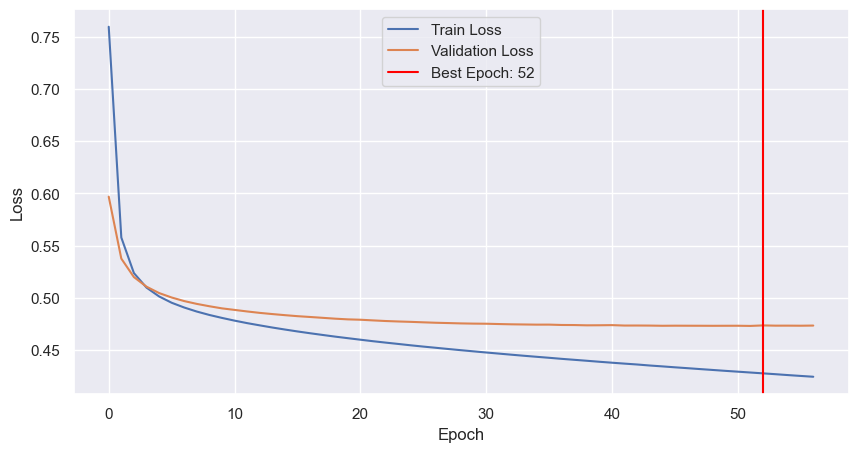

In [77]:
# plot train and validation loss using seaborn, mark best epoch with veritcal line
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.axvline(best_epoch, color="red", label=f"Best Epoch: {best_epoch}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [93]:
# baseline model
# we use the mean of the training set as the prediction for all test samples
# we use the mean of the training set as the prediction for all test samples
mean = np.mean(train_set.dataset.y.numpy(), axis=0)
baseline_predictions = np.tile(mean, (len(test_set.dataset), 1))
baseline_r2 = r2_score(test_set.dataset.y.numpy(), baseline_predictions)
baseline_loss = criterion(torch.from_numpy(baseline_predictions), torch.from_numpy(test_set.dataset.y.numpy())).item()
print(f"Baseline Loss: {baseline_loss:.4f}, Baseline R2: {baseline_r2:.4f}")

Baseline Loss: 0.6876, Baseline R2: 0.0000


In [ ]:
# stats
# using 5 closest cells: 0.11 R2 on test set
# using 1 closest cells: 0.14 R2 on test set
# using 2 closest cells: 0.135 R2 on test set
# using 10 closest cells: x.xx R2 on test set